<a href="https://colab.research.google.com/github/Springboard-CourseDev/MachineLearningForEngineers/blob/master/Solutions/Mini_Project_3_Evaluate_the_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 3: Evaluate the Model

In this project you'll get the opportunity to build a machine learning pipeline from scratch. As in the previous projects, we'll be using the [Kaggle Heart Disease Dataset](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data). The objectives of this project are three-fold:

  * Use the highly versatile `Pipeline` object in Scikit-Learn to build a machine learning pipeline with column transformations.  
  * Explore overfitting/underfitting a model. 
  * Understand how to apply hyperparameter turning 



## Load the Data

First, import the base libraries we'll be using. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

Load the Kaggle Heart Disease dataset. 

In [2]:
heart_df = pd.read_csv('/content/heart_disease.zip')

Split the data into a training and test set using `train_test_split`.

In [3]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        heart_df.iloc[:, ~heart_df.columns.isin(['target'])], 
        heart_df['target'], 
        test_size=0.2,
        random_state=42,
        shuffle=True
    )
)

In [4]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
835,49,1,2,118,149,0,0,126,0,0.8,2,3,2
137,64,0,0,180,325,0,1,154,1,0.0,2,0,2
534,54,0,2,108,267,0,0,167,0,0.0,2,0,2
495,59,1,0,135,234,0,1,161,0,0.5,1,0,3
244,51,1,2,125,245,1,0,166,0,2.4,1,0,2


## Build a Pipeline

The Scikit-Learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows one to take raw data, apply transformations, and train a model in one structure. This object can be saved and stored for use elsewhere in a production environment. The list of available transformations in Scikit-Learn can be found [here](https://scikit-learn.org/stable/modules/preprocessing.html), although custom transformations are also possible. Since you've already completed exploratory data analysis in the previous project, you should have a good sense of what transformations can be applied to the feature set in the heart disease dataset. In this section, let's applly the following transformations:

  * **age** - KBins Discretizer
  * **sex** - Leave Alone
  * **cp** - One Hot Encoder 
  * **trestbps** - Standard Scaler
  * **chol** - Standard Scaler
  * **fbs** - Leave Alone
  * **restecg** - One Hot Encoder 
  * **thalach** - Standard Scaler 
  * **exang** - Leave Alone
  * **oldpeak** - KBins Discretizer
  * **slope** - One Hot Encoder 
  * **ca** - One Hot Encoder 
  * **thal** - One Hot Encoder 

Import Scikit-Learn's relevant pipeline libraries.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

**Exercise**: Write a `Pipeline` object that has two steps. In the first step, the pipeline applies all the discussed transformations to the feature set using `ColumnTransformer`. In the second step, the pipeline trains a `DecisionTreeClassifier` with default parameters. Don't forget to passthrough the features that don't need processing. 

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(
            categories='auto',
            handle_unknown='ignore',
            sparse=False),
         ['cp', 'restecg', 'slope', 'ca', 'thal']),
        ('standard_scaler', StandardScaler(),
         ['trestbps', 'chol', 'thalach']),
        ('kbd', KBinsDiscretizer(
            n_bins=5, 
            encode='onehot-dense', 
            strategy='uniform'),
         ['age', 'oldpeak'])
    ],
    remainder = 'passthrough'
)

pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]
)

## Plotting a Validation Curve

**Exercise**: [Validation curves](https://towardsdatascience.com/validation-curve-explained-plot-the-influence-of-a-single-hyperparameter-1ac4864deaf8#) can provide insight into a model underfitting, overfitting, or being just right. Scikit-Learn provides a function [`validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) that simplifies the process of making a validation curve. Use this function and the `Pipeline` you created to plot training and validation F1 scores for the `max_depth` parameter of the `DecisionTreeClassifier`. For the cross-validation generator input 
use [`ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

**Exercise**: For which values of `max_depth` is the model over-fitting? Underfitting? Just right?

*Hint -- To access parameter names in a pipeline use the syntax e.g. pipe.get_params().keys()*


In [7]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score

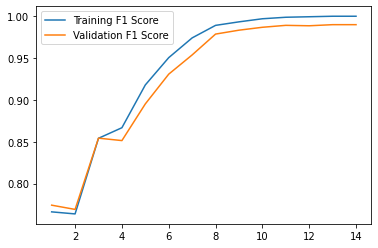

In [8]:
ss = ShuffleSplit(n_splits=10, test_size=0.2)

X = heart_df.iloc[:, ~heart_df.columns.isin(['target'])] 
y = heart_df['target']

max_depth = range(15)
train_scores, test_scores = validation_curve(
    pipe, X, y, 
    param_name='classifier__max_depth', 
    param_range=max_depth,
    cv=ss, scoring='f1', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

sns.lineplot(x=max_depth, y=train_mean, label='Training F1 Score');
sns.lineplot(x=max_depth, y=test_mean, label='Validation F1 Score');

## Hyperparameter Tuning

In machine learning hyperparameters are everywhere from the models themselves, to feature transformation meta data. Often, the hyperparameter values have a significant impact on model performance, which is why settling on optimal hyperparameter values is important. Unfortunately, hyperparameter tuning is a difficult problem because it requires training a model over and over again, which can get computationally expensive. 


For this reason, it's important to use an efficient algorithm for hypeparameter tuning. Grid search, while simple to understand, is not efficient because the search space tried is exponential with the number of parameters being tuned. Bayesian-based hyperparameter tuning libraries, like [Hyperopt](http://hyperopt.github.io/hyperopt/), are considered much more efficient than random search or grid approaches because the ignore areas of the search space that have no impact on the minimization function. 

![](https://miro.medium.com/max/1400/1*2gsysrNnSD-n8HDCHmpZFw.jpeg) [Source](https://towardsdatascience.com/hyperopt-hyperparameter-tuning-based-on-bayesian-optimization-7fa32dffaf29)

In this section, you'll use the hyperopt library to perform hyperparameter tuning on your pipeline. 

Import some useful libraries.

In [9]:
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import hp
from hyperopt import anneal
from hyperopt import Trials
from hyperopt import space_eval
from sklearn.model_selection import cross_val_score

**Exercise**: The Hyperopt library requires a function to minimize, as described in the [documentation](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/). Write a function that passes parameter values for the `DecisionTreeClassifier` in your pipeline and returns a cross validation score for the f1 metric. The hyperparameters for `DecisionTreeClassifier` to be tweaked are `max_depth`, `max_features`, and `criterion`.  

Data should be passed to your pipeline that applies all feature transformations. Use Scikit-Learn's [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to output the cross-validated f1 metric.  

Remember, Hyperopt works to minimize functions. *Minimize* is the key word here. For the f1 metric, bigger is better and so your function should return the negative f1 score.  

In [10]:
ss = ShuffleSplit(n_splits=10, test_size=0.2)

def decision_tree_f1_cv(params, X=X_train, y=y_train, cv=ss):
  params = {
      'max_depth': int(params['max_depth']), 
      'max_features': int(params['max_features']), 
      'criterion': params['criterion']
  }
  pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=params['max_depth'], 
            max_features=params['max_features'],
            criterion=params['criterion']
            )
        )
    ]
  )
  score = -cross_val_score(pipe, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
  return score

**Exercise**: Now that you've written a function to minimize, set up Hyperopt to find the parameters `max_depth`, `max_features`, and `criterion` that minimize the function. First, you'll have to define the search space for each of these variables. Also, make sure to use a `Trials()` object to keep logging information.  

In [11]:
# possible values of parameters
space = {
    'max_depth': hp.quniform('max_depth', 1, 20, 1),
    'max_features' : hp.quniform('max_features', 1, 30, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# trials will contain logging information
trials = Trials()

best = fmin(
    fn=decision_tree_f1_cv, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials, 
    rstate=np.random.RandomState(47)
)

100%|██████████| 100/100 [00:28<00:00,  3.53it/s, best loss: -0.9876980833985209]


**Exercise**: Once Hyperopt is finishing calculating optimal parameters, view the findings using the `space_eval` function. 

In [12]:
se_best = space_eval(space, best)
se_best

{'criterion': 'entropy', 'max_depth': 19.0, 'max_features': 9.0}

**Exercise**: Build the `Pipeline` object for a `DecisionTreeClassifier` initialized with the optimal parameters found. Train the pipeline and then calculate the f1 score on the test data.  

In [13]:
# computing the score on the test set
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=int(se_best['max_depth']), 
            max_features=int(se_best['max_features']), 
            criterion=se_best['criterion']
            )
        )
    ]
)


pipe.fit(X_train, y_train)
tpe_test_score = f1_score(y_test, pipe.predict(X_test))
print(tpe_test_score)

1.0
